## Image pre|post-processing

In [23]:
import os
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline
#plt.style.use('fivethirtyeight')
#plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 14

In [24]:
# Random image name generator
def get_rand_name(size=30, chars=string.ascii_letters + string.digits):
    return ''.join(random.choice(chars) for x in range(size))

In [32]:
# Load dataset
#PATH = os.getcwd()
TRAIN = "../input/vessels-data/training/"
TRAIN_FINAL = "../input/vessels-data/training_final/"

[  0 255]
(584, 565)


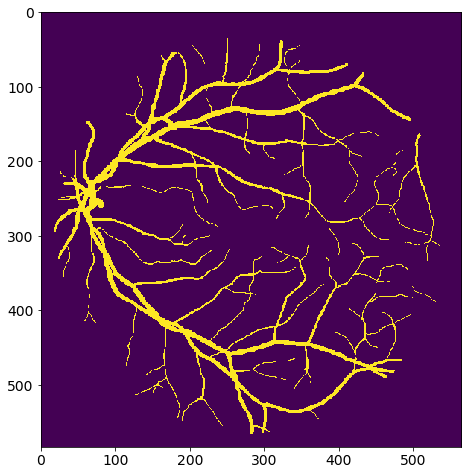

In [30]:
# original dimension: 584x565
# modified dimension: 576x560 
def load_image(path):
    # Load training
    fnames = os.listdir(path)
    for f in fnames:
        #image = cv2.imread(os.path.join(path, f"images/{f}"))
        image = plt.imread(os.path.join(path, f))
        #mask_in_gray = cv2.cvtColor(mask_in, cv2.COLOR_BGR2GRAY)
        print(np.unique(image))
        print(image.shape)
        plt.imshow(image)
        break
        
        
load_image(FRAME_TRAIN_PATH)

In [ ]:
def apply_rotate(path, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rotation, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def apply_noise(image):
    height, width, channel = image.shape
    

# Offline image augmentation

In [31]:
# Augmentation using albumentation 
# https://albumentations.readthedocs.io/en/latest/examples.html
import albumentations as alb
import random 
import numpy as np

In [ ]:
img_in = os.path.join(DEST_PATH, 'frames_sliced/')
mask_in = os.path.join(DEST_PATH, 'masks_sliced/')
img_out = os.path.join(DEST_PATH, 'frames_sliced_aug/')
mask_out = os.path.join(DEST_PATH, 'masks_sliced_aug/')

In [ ]:
def generate_aug_img(p=0.7, img_in='', mask_in='', img_out='', mask_out=''):
    # define augmentation pipeline
    pipeline = alb.Compose([
        alb.VerticalFlip(),
        alb.HorizontalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1),
        alb.ElasticTransform(border_mode=cv2.BORDER_REFLECT_101, alpha_affine=40, p=1),
        alb.OneOf([
            alb.GaussianBlur(p=0.7, blur_limit=3),
            alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
            alb.RandomSnow(p=0.7, brightness_coeff=1, snow_point_lower=0.3, snow_point_upper=0.5),
            alb.RandomShadow(p=0.6, num_shadows_lower=1, num_shadows_upper=1, 
                            shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1)),
            alb.RandomFog(p=0.7, fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1)
        ], p=0.8),
        alb.OneOf([
            alb.CLAHE(clip_limit=2),
            alb.IAASharpen(),
            alb.IAAEmboss(),
            alb.RandomBrightnessContrast(),
        ], p=0.6),
    ], p=p)
    
    # Apply pipeline for randomly picked image for 800 trial -> to generate 800 images
    for _ in range(800):
        # Shuffle out image list
        img_list = os.listdir(img_in)
        random.shuffle(img_list)
        index = random.randint(0, len(img_list)-1)
        # Pick one image 
        img_id = img_list[index]
        # Apply augmentation to the coosen image
        _img_in = cv2.imread(img_in + img_id)
        _mask_in = cv2.imread(mask_in + img_id)
        # Fit pipeline 
        augmented = pipeline(image = _img_in, mask = _mask_in)
        # Get outcomes 
        _img_out, _mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        out_fname = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(img_out + out_fname + '.png', _img_out)
        cv2.imwrite(mask_out + out_fname + '.png', _mask_out)
        
#generate_aug_img(p=0.8, img_in=img_in, mask_in=mask_in, img_out=img_out, mask_out=mask_out)

In [ ]:
def generate_aug_img_tmp(p=0.9, img_in='', mask_in='', img_out='', mask_out=''):
    # define augmentation pipeline
    pipeline = alb.Compose([
       alb.GaussianBlur(p=0.9, blur_limit=30),
    ], p=p)
    
    # Apply pipeline for each image 
    for _ in range(20):
        # Shuffle out image list
        img_list = os.listdir(img_in)
        random.shuffle(img_list)
        index = random.randint(0, len(img_list)-1)
        # Pick random one image 
        img_id = img_list[index]
        # Apply augmentation to the choosen image
        _img_in = cv2.imread(img_in + img_id)
        _mask_in = cv2.imread(mask_in + img_id)
        #_img_in = cv2.imread(img_in)
        #_mask_in = cv2.imread(mask_in)
        
        
        # Fit pipeline 
        augmented = pipeline(image = _img_in, mask = _mask_in)
        # Get outcomes 
        _img_out, _mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        out_fname = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(os.path.join(img_out, out_fname + '.png'), _img_out)
        cv2.imwrite(os.path.join(mask_out, out_fname + '.png'), _mask_out)

In [ ]:
def generate_img(p=1, img_in='', img_out=''):
    # define augmentation pipeline
    pipeline = alb.Compose([
       #alb.GaussianBlur(p=0.9, blur_limit=30),
        alb.CLAHE(clip_limit=2.5),
    ], p=p)
    
    _img_in = cv2.imread(img_in)
    augmented = pipeline(image = _img_in)
    _img_out = augmented["image"]
    out_fname = get_rand_name()
    # Write file to out dir 
    cv2.imwrite(os.path.join(img_out, out_fname + '.png'), _img_out)
    
generate_img(img_in=PATH, img_out=DEST_PATH)

In [ ]:

img_in = '/media/zero/STUDY/GIT REPO/ml-deep-learning/13-ann-road-classification/dataset-loader/experiments/frame321/frame/'
mask_in = '/media/zero/STUDY/GIT REPO/ml-deep-learning/13-ann-road-classification/dataset-loader/experiments/frame321/mask/'
img_out = '/media/zero/STUDY/GIT REPO/ml-deep-learning/13-ann-road-classification/dataset-loader/experiments/frame321/aug/frame'
mask_out = '/media/zero/STUDY/GIT REPO/ml-deep-learning/13-ann-road-classification/dataset-loader/experiments/frame321/aug/mask'

In [ ]:
generate_aug_img_tmp(img_in = img_in, mask_in = mask_in, img_out = img_out, mask_out = mask_out)